In [58]:
from helpers import load_data, roc_plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier # pip install imblearn - scikit wrapper
from sklearn import ensemble, pipeline, model_selection, metrics, preprocessing, svm


DATA_PATH = '../data/'
PKL_PATH = '../pickles/'
seed = 7

data = load_data(DATA_PATH)
X, y = data['muchlinski']

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
kernels = ['poly','linear','rbf','sigmoid']
k_folds = 5
degrees = np.arange(1,8)
class_weights = [{0:1, 1:2**i} for i in range(5)]
penalties = [0.001,0.01,0.05,1,2.5,5]

res = []

scoring=['precision','recall','f1','roc_auc']

for kernel in kernels:
    for class_weight in class_weights:
        for penalty in penalties: 
            if kernel=='poly':
                # if polynomial kernel try multiple degrees
                for d in degrees:
                    # define pipeline and cross validate
                    pipe = pipeline.make_pipeline(preprocessing.StandardScaler(), svm.SVC(random_state=seed, class_weight=class_weight, C=penalty, kernel=kernel))
                    scores = model_selection.cross_validate(pipe, X=X, y=y, cv=k_folds, scoring=scoring, return_train_score=False)

                    # create backlog of results
                    cv_res = [kernel, class_weight[1], penalty, d, np.mean(scores['test_precision']), np.mean(scores['test_recall']), np.mean(scores['test_f1']), np.mean(scores['test_roc_auc'])] 
                    res.append(cv_res)
            else:
                # define pipeline and cross validate
                pipe = pipeline.make_pipeline(preprocessing.StandardScaler(), svm.SVC(random_state=seed, class_weight=class_weight, C=penalty, kernel=kernel))
                scores = model_selection.cross_validate(pipe, X=X, y=y, cv=k_folds, scoring=scoring, return_train_score=False)

                # create backlog of results
                cv_res = [kernel, class_weight[1], penalty, np.nan, np.mean(scores['test_precision']), np.mean(scores['test_recall']), np.mean(scores['test_f1']), np.mean(scores['test_roc_auc'])] 
                res.append(cv_res)
        
res = pd.DataFrame(np.vstack(res), columns=['kernel','class_1_weight','penalty','degree','prec','rec','f1','roc_auc'])

In [55]:
res.to_pickle(PKL_PATH+'svm_cv_res.pkl')

## ROC-AUC plot

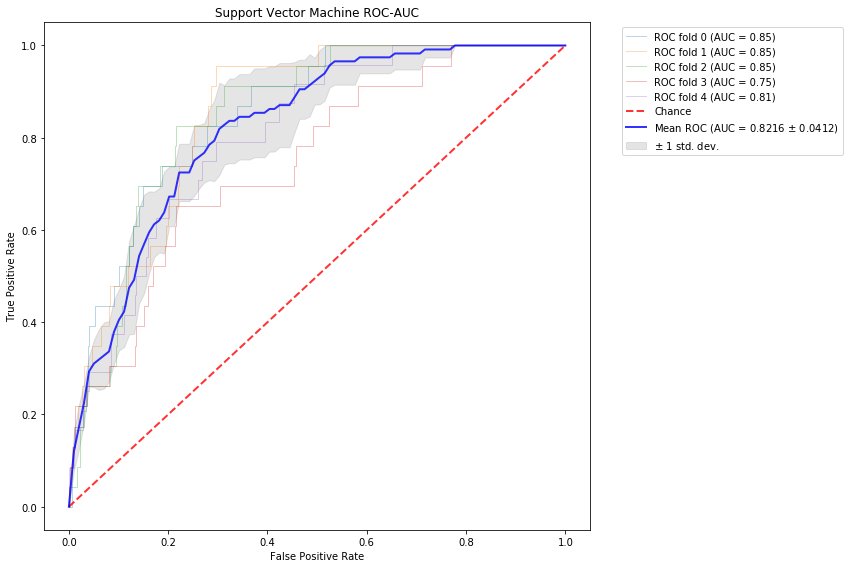

In [57]:
res = pd.read_pickle(PKL_PATH+'svm_cv_res.pkl')
res = res.astype({'class_1_weight':'int','penalty':'float','prec':'float','rec':'float','f1':'float','roc_auc':'float'})
res['avg'] = (res['f1']+res['roc_auc'])/2

kernel, class_1_weight, penalty, degree = res.loc[np.argsort(res['avg'])][::-1][['kernel','class_1_weight','penalty','degree']].iloc[0]
class_weight = {0:1, 1:class_1_weight}

pipe = pipeline.make_pipeline(preprocessing.StandardScaler(), 
                              svm.SVC(random_state=seed, class_weight=class_weight, C=penalty, kernel=kernel, degree=1 if degree=='nan' else degree))
svm_res = roc_plt(X, y, pipe, "Support Vector Machine ROC-AUC", seed=seed)

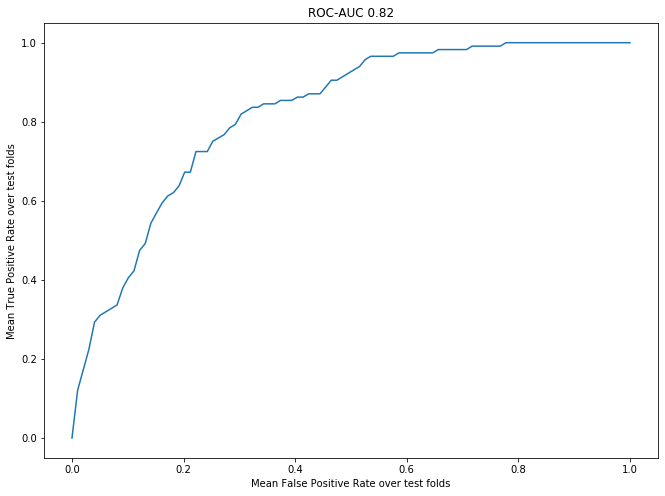

In [72]:
fig, axs = plt.subplots(figsize=(11,8))
g = sns.lineplot(svm_res['mean_fpr'], svm_res['mean_tpr'])
g.set_xlabel('Mean False Positive Rate over test folds')
g.set_ylabel('Mean True Positive Rate over test folds')
g.set_title('ROC-AUC {0:.2f}'.format(svm_res['mean_auc']))
plt.show()

## Feature importances

Note that feature importances are here computed by their coefficients, and that it is not possible to compute these in non-linear spaces as the coefficients would then not correspond to the input space.

In [83]:
res = pd.read_pickle(PKL_PATH+'svm_cv_res.pkl')
res = res.astype({'class_1_weight':'int','penalty':'float','prec':'float','rec':'float','f1':'float','roc_auc':'float'})
res['avg'] = (res['f1']+res['roc_auc'])/2

lin_res = res.loc[res['kernel']=='linear'].reset_index(drop=True)
kernel, class_1_weight, penalty, degree = lin_res.loc[np.argsort(lin_res['avg'])][::-1][['kernel','class_1_weight','penalty','degree']].iloc[0]

pipe = pipeline.make_pipeline(preprocessing.StandardScaler(), 
                              svm.SVC(random_state=seed, class_weight=class_weight, C=penalty, kernel=kernel, degree=1 if degree=='nan' else degree))
pipe.fit(X, y)

coef = abs(pd.Series(pipe['svc'].coef_[0]))
names = pd.Series(X.columns)
importances = pd.concat([coef,names],axis=1).rename(columns={0:'importances',1:'features'}).loc[np.argsort(coef)][::-1]

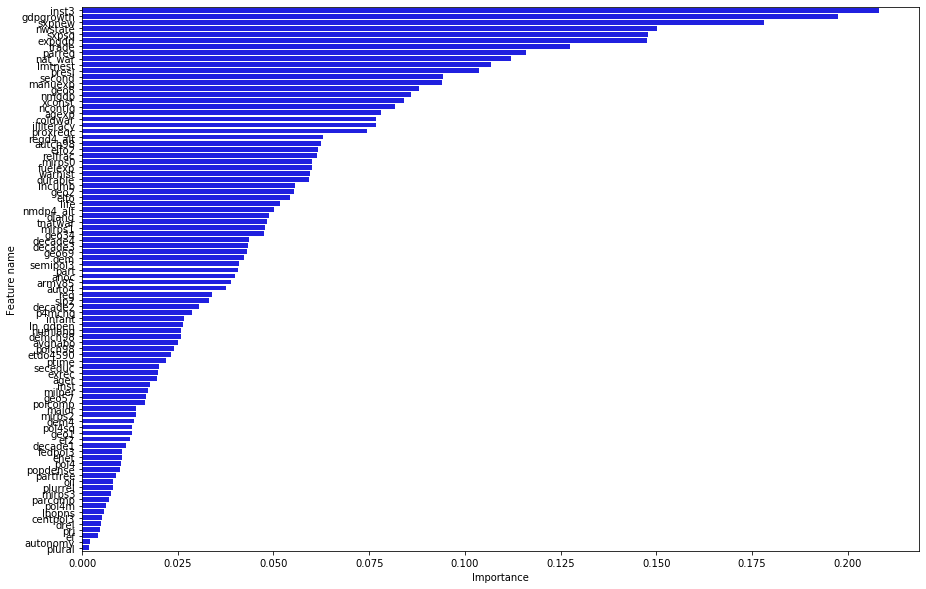

In [144]:
fig, axs = plt.subplots(figsize=(15,10))
g = sns.barplot('importances', 'features', data=importances, color='b')
g.set_xlabel('Importance')
g.set_ylabel('Feature name')
plt.show()

## F1 score 